# Week 2 - Counting Words & Phrases (Computational Linguistics)
This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora.

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora.

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text.

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to c:\users\admin\appdata\local\temp\pip-req-build-u7ypjawk
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-u7ypjawk'


# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link (shared on Canvas, not here, because the GitHub is publically accessible). The same code can be modified slighlty to access the rest of the corpora on RCC. There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [ ]:
corpus_name = "/Users/bhargavvader/Downloads/Movies/"

# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [ ]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [ ]:
movie_raw = loadcorpus(corpus_name)

In [ ]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [ ]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [ ]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [ ]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded.

In [ ]:
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on.

To perform a tokenization, we check if the string includes punctuation and add this token.

In [ ]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
word_tokenize(clean_11[1])

You can see how the sentence is broken into its constituent words. We can then do some analysis with this.

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [ ]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [ ]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [ ]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
...,...,...
248,postman,10
187,please,9
328,but,9
215,as,9


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial.

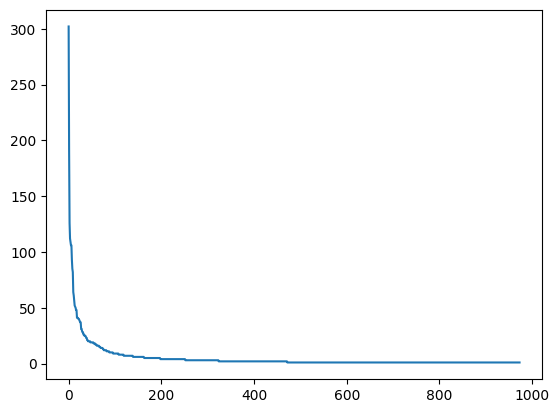

In [ ]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

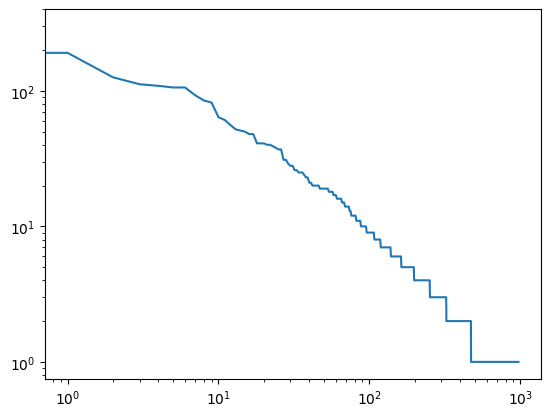

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.)

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'has_discussions', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_

What we are interested in here is the `'contents_url'`

In [ ]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [ ]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [ ]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [ ]:
import nltk

In [ ]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText)
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [ ]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [ ]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

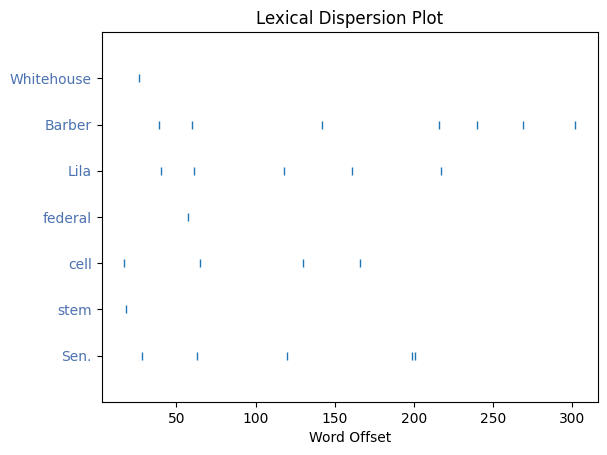

In [ ]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [ ]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [ ]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [ ]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [ ]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

# <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </font>

### About my corpus

My analysis revolves around a unique corpus structure primarily composed of "drama-like" texts. This format is characterized by pieces of dialogue or monologue, each explicitly linked to a specific character who speaks or thinks these lines. Imagine a traditional script where every line of dialogue is attributed to a character – that's the essence of this drama-like structure.

In this corpus, **each text segment – whether a statement, question, or expository comment – is associated with a character** from a movie, anime, or game. (I'm demonstrating with a game ) This allows us to analyze not just the content of the text, but also the patterns and nuances of character-specific speech and behavior.

In [2]:
file_path = 'D://MACSS PROGRAM/30122/MACS-60000-2024-Winter/data/Arknights_plot'

In [3]:
## My code to extract my corpus files

import os
import re
import pandas as pd

def list_files(directory):
    """List all .xlsx files in the given directory."""
    return [file for file in os.listdir(directory) if file.endswith('.xlsx')]

def categorize_files(file_list):
    """Categorize files into main and side stories."""
    main_stories = []
    side_stories = []
    for file in file_list:
        if re.match(r"main_\d+_", file):
            main_stories.append(file)
        elif re.match(r"act\d+.*?_", file):
            side_stories.append(file)
    return main_stories, side_stories

def read_xlsx(file_path):
    """Read .xlsx file and return a list of dataframes, each representing a table (scene)."""
    return pd.read_excel(file_path, sheet_name=None)

def extract_dialogues(dataframes):
    """Extract characters and dialogues from each scene."""
    extracted_data = []
    for df in dataframes.values():
        # Adjusting to index-based access (1 for 'B' and 2 for 'C')
        scene_data = {
            'characters': df.iloc[:, 1].tolist(),  # Column 'B'
            'dialogues': df.iloc[:, 2].tolist()    # Column 'C'
        }
        extracted_data.append(scene_data)
    return extracted_data


In [4]:
file_path = 'D://MACSS PROGRAM/30122/MACS-60000-2024-Winter/data/Arknights_plot'
files = list_files(file_path)
main_stories, side_stories = categorize_files(files)

all_data = {'main_stories': {}, 'side_stories': {}}
for story in main_stories:
    dfs = read_xlsx(os.path.join(file_path, story))
    all_data['main_stories'][story] = extract_dialogues(dfs)

for story in side_stories:
    dfs = read_xlsx(os.path.join(file_path, story))
    all_data['side_stories'][story] = extract_dialogues(dfs)

In [5]:
all_data['main_stories'].keys() # there are 13 main stories in total


dict_keys(['main_0_Evil Time Part 1.xlsx', 'main_10_Shatterpoint.xlsx', 'main_11_Return To Mist.xlsx', 'main_12_All Quiet Under the Thunder.xlsx', 'main_1_Evil Time Part 2.xlsx', 'main_2_Separated Hearts.xlsx', 'main_3_Stinging Shock.xlsx', 'main_4_Burning Run.xlsx', 'main_5_Necessary Solutions.xlsx', 'main_6_Partial Necrosis.xlsx', 'main_7_The Birth of Tragedy.xlsx', 'main_8_Roaring Flare.xlsx', 'main_9_Stormwatch.xlsx'])

In [6]:
for story_name, scenes in all_data['main_stories'].items():
    print(f"In {story_name}, there are {len(scenes)} scenes")

In main_0_Evil Time Part 1.xlsx, there are 14 scenes
In main_10_Shatterpoint.xlsx, there are 28 scenes
In main_11_Return To Mist.xlsx, there are 27 scenes
In main_12_All Quiet Under the Thunder.xlsx, there are 27 scenes
In main_1_Evil Time Part 2.xlsx, there are 12 scenes
In main_2_Separated Hearts.xlsx, there are 20 scenes
In main_3_Stinging Shock.xlsx, there are 16 scenes
In main_4_Burning Run.xlsx, there are 20 scenes
In main_5_Necessary Solutions.xlsx, there are 17 scenes
In main_6_Partial Necrosis.xlsx, there are 27 scenes
In main_7_The Birth of Tragedy.xlsx, there are 20 scenes
In main_8_Roaring Flare.xlsx, there are 39 scenes
In main_9_Stormwatch.xlsx, there are 20 scenes


In [5]:
# Initialize an empty DataFrame
main_plots_df = pd.DataFrame(columns=['Story', 'Character', 'Dialogue'])

# Iterate over each main story
for story_name, scenes in all_data['main_stories'].items():
    for scene in scenes:
        # Extract characters and dialogues
        characters = scene['characters']
        dialogues = scene['dialogues']

        # Create a DataFrame for the current story
        story_df = pd.DataFrame({
            'Story': story_name,
            'Character': characters,
            'Dialogue': dialogues
        })

        # Append this DataFrame to the main DataFrame
        main_plots_df = pd.concat([main_plots_df, story_df], ignore_index=True)

# Now main_plots_df contains all dialogues from all main stories


In [8]:
main_plots_df

,Story,Character,Dialogue
0,main_0_Evil Time Part 1.xlsx,----,----
1,main_0_Evil Time Part 1.xlsx,--image--,https://raw.githubusercontent.com/Aceship/Arkn...
2,main_0_Evil Time Part 1.xlsx,--imagetween--,https://raw.githubusercontent.com/Aceship/Arkn...
3,main_0_Evil Time Part 1.xlsx,--imagetween--,https://raw.githubusercontent.com/Aceship/Arkn...
4,main_0_Evil Time Part 1.xlsx,NaN,It's been a long time since we've last seen...
...,...,...,...
49825,main_9_Stormwatch.xlsx,----,----
49826,main_9_Stormwatch.xlsx,Talulah,"But, right now, it looks like this place nee..."
49827,main_9_Stormwatch.xlsx,Talulah,—I'd better hurry and start a fire.
49828,main_9_Stormwatch.xlsx,----,----


In [6]:
## Use Regex to clean the data and remove unwanted rows

def clean_story_titles(df):
    """ Clean story titles and remove rows with NaN in both Character and Dialogue. """
    # Clean story titles
    df['Story'] = df['Story'].apply(lambda x: re.sub(r"main_(\d+)_(.+)\.xlsx", r"\1. \2", x))
    
    # Remove rows where both Character and Dialogue are NaN
    df.dropna(subset=['Character', 'Dialogue'], how='all', inplace=True)
    
    return df

def remove_unwanted_rows(df):
    """ Remove rows that indicate page-turning or image changes. """
    # Remove rows with '--(words)--' in Character column
    df = df[~df['Character'].str.match(r"--.*?--", na=False)]
    
    return df

In [7]:
main_plots_df = clean_story_titles(main_plots_df)
main_plots_df = remove_unwanted_rows(main_plots_df)

The above function clean the titles and remove all unwanted line (empty lines or non-literature portion like presentation in cutscene)
- When Character is NaN, the Dialogue refers to some voice-over-like narratage

In [11]:
main_plots_df


,Story,Character,Dialogue
4,0. Evil Time Part 1,NaN,It's been a long time since we've last seen...
5,0. Evil Time Part 1,NaN,During this time... you've been teetering o...
7,0. Evil Time Part 1,NaN,"You may have forgotten who you are, but jus..."
9,0. Evil Time Part 1,NaN,...It's time. Don't linger here for too long.
10,0. Evil Time Part 1,NaN,"After all, you aren't my guest yet, nor sho..."
...,...,...,...
49822,9. Stormwatch,Talulah,Looks like I need to get used to this weathe...
49823,9. Stormwatch,Talulah,"Sorry, I can't take too long. I need to go n..."
49824,9. Stormwatch,Talulah,"One day, we will make it through this snowst..."
49826,9. Stormwatch,Talulah,"But, right now, it looks like this place nee..."


#### Tokenize and counting words in dialogues

In [12]:
from collections import Counter

Try spacy first, also test with Counter in a intuitive way to see the efficiency.

In [13]:
nlp = spacy.load("en_core_web_sm")

def tokenize_dialogues(df):
    """ Tokenize the dialogues and count the words. """
    word_count = Counter()

    for dialogue in df['Dialogue'].dropna():
        doc = nlp(dialogue)
        tokens = [token.text.lower() for token in doc if token.is_alpha]  # Filter out punctuation and numbers (I'll leave other stopword for next exercise)
        word_count.update(tokens)
    
    return word_count

word_count = tokenize_dialogues(main_plots_df)


In [14]:
# see something in the middle
word_count.most_common(1000)[500:520]

[('standing', 93),
 ('fought', 92),
 ('running', 92),
 ('whatever', 92),
 ('step', 92),
 ('haha', 92),
 ('blaze', 92),
 ('cover', 91),
 ('military', 91),
 ('real', 91),
 ('escape', 90),
 ('met', 90),
 ('making', 89),
 ('however', 89),
 ('start', 89),
 ('weapon', 89),
 ('strong', 89),
 ('general', 89),
 ('less', 88),
 ('fear', 88)]

Try an **nltk** object

In [15]:
import nltk

In [16]:
# try if I can have an object of each dialogue

def dialogues_to_nltk_text(df):
    """Converts the dialogue column of the DataFrame into a list of nltk Text objects."""
    # Tokenize each dialogue
    tokenized_dialogues = df['Dialogue'].apply(lambda x: nltk.tokenize.word_tokenize(str(x)))

    # Convert tokenized dialogues into nltk Text objects
    nltk_texts = [nltk.Text(tokens) for tokens in tokenized_dialogues]

    return nltk_texts

In [17]:
nltk_dialogues = dialogues_to_nltk_text(main_plots_df)

In [18]:
nltk_dialogues[29] # we can see each dialogue are short

<Text: Medic , how 's Doctor doing ?...>

In [19]:
# count between dialogue 10000 and 10010, how many words in each dialogue?
for i in range(10000, 10010):
    print(len(nltk_dialogues[i]))

1
16
25
6
12
15
15
12
19
3


In [20]:
## A function to make larger nltk objects around e.g characters or stories
## It is more meaningful to see the whole story or the whole character's dialogues together

def create_nltk_objects(df, group_by):
    """
    Group dialogues and convert them into NLTK Text objects, based on the specified criterion.

    :param df: DataFrame containing the story data.
    :param group_by: Column name to group the data (e.g., 'Story', 'Character').
    :return: DataFrame with grouped dialogues as NLTK Text objects.
    """
    # Group by the specified criterion and aggregate dialogues into lists
    grouped = df.groupby(group_by)['Dialogue'].apply(list).reset_index()

    # Create a new column for the NLTK Text objects
    grouped['NLTK_Text'] = grouped['Dialogue'].apply(lambda dialogues: 
                                                     nltk.text.Text( 
                                                     nltk.word_tokenize(' '.join(dialogues)))
                                                     )## simply connect all dialogues together

    return grouped


In [21]:
nltk_texts_by_character = create_nltk_objects(main_plots_df, 'Character')

In [22]:
nltk_texts_by_character

,Character,Dialogue,NLTK_Text
0,'Deathless Black Snake',"[ Amiya, oh Amiya. Do you know why you are so ...","(Amiya, ,, oh, Amiya, ., Do, you, know, why, y..."
1,'Emperors' Blade',"[ *Hiss*., You didn't tell them who you rea...","(*, Hiss, *, ., You, did, n't, tell, them, who..."
2,'Golding',"[Don't get the wrong idea, Golding. We don't a...","(Do, n't, get, the, wrong, idea, ,, Golding, ...."
3,'Iberian',"[Patience, Banshee. These were the most unforg...","(Patience, ,, Banshee, ., These, were, the, mo..."
4,'Kazimierzian',[I often feel that the times change with irreg...,"(I, often, feel, that, the, times, change, wit..."
...,...,...,...
360,Young Man's Voice,[ ...Damn it... Why... Even though we're all...,"(..., Damn, it, ..., Why, ..., Even, though, w..."
361,Young Soldier,"[Yes, Captain!, Yes, I suppose it went rather ...","(Yes, ,, Captain, !, Yes, ,, I, suppose, it, w..."
362,Young Ursus Student,"[Hello, are you here to listen in on Miss Kosh...","(Hello, ,, are, you, here, to, listen, in, on,..."
363,Young Volunteer,"[But I washed them already..., Jane, look, I k...","(But, I, washed, them, already, ..., Jane, ,, ..."


In [23]:
# let's find which character has longest dialogues: top 5 (29, 152, 316, 56, 137)
nltk_texts_by_character['NLTK_Text'].apply(lambda x: len(x)).sort_values(ascending=False)


29     43670
152    31693
316    19201
56     18343
137    11218
       ...  
307        2
222        2
191        1
230        1
227        1
Name: NLTK_Text, Length: 365, dtype: int64

In [24]:
# Theses are the top 5 characters with longest dialogues
nltk_texts_by_character.iloc[[29, 152, 316, 56, 137]]

,Character,Dialogue,NLTK_Text
29,Amiya,"[ Ah... S-sorry., ...I'm already mentally...","(Ah, ..., S-sorry, ., ..., I, 'm, already, men..."
152,Kal'tsit,[ Good. Ensure the boarding region can operat...,"(Good, ., Ensure, the, boarding, region, can, ..."
316,Talulah,"[......, Miss... Koshelna?, No need. Her voice...","(......, Miss, ..., Koshelna, ?, No, need, ., ..."
56,Ch'en,"[Why would I do that?, I'm sorry?, There's a w...","(Why, would, I, do, that, ?, I, 'm, sorry, ?, ..."
137,Horn,"[Horn, if it pleases you., ......, It's my fau...","(Horn, ,, if, it, pleases, you, ., ......, It,..."


In [25]:
# Work on second character: 152 "Kal'tsit"

kaltsit_nltk = nltk_texts_by_character['NLTK_Text'].iloc[152]



In [26]:
kaltsit_nltk.concordance('Amiya') # "Amiya" is the character with most dialogues

Displaying 25 of 108 matches:
r what comes next ... that lies with Amiya and Vina . Docking complete . Quiet 
 not even when she was still alive . Amiya knows her role . We do n't want a wa
rkaz court . Is that why you allowed Amiya into Londinium ? The nachzehrer take
did n't . And that 's because of ... Amiya . You will . She will surpass what y
 , or information on the powers that Amiya has inherited . ...... At this point
 n't deny the importance you hold to Amiya , and the thing she needs most in th
in , W ? Dr. { @ nickname } ... Take Amiya ... go . Theresis ... * cough * ... 
 am I ... ? Where are the Doctor and Amiya ? Sounds like they 're both fine , f
e news sometimes as well , Closure . Amiya ... ... { @ nickname } . So you 've 
on Chernobog fell within one night ? Amiya . ... ... Rhodes Island 's asking pr
 please elaborate , Mister Wei ? ... Amiya ? Amiya , you 'll eventually have to
elaborate , Mister Wei ? ... Amiya ? Amiya , you 'll eventually have to learn h
what happe

In [27]:
kaltsit_nltk.common_contexts(['Amiya']) 
## Warning: This is NOT useful; we are not supposed to concate all dialogues together, 
# and there are lots of punctuations in the tokenized dialogues,
# might want to use some tag for begin and end of each dialogue to see the context

,_. ._, ._... ,_, ._. ._is ?_, ......_, ._'s ..._... with_and ._knows
allowed_into ..._. that_has to_, take_... and_? ?_. ..._?


In [28]:
# Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
words_to_plot = ['Amiya', 'Lungmen', 'Catastrophe']
kaltsit_nltk.dispersion_plot(words_to_plot)
sns.set() #Re-enabling seaborn



# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary).

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word.

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest.

In [ ]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [ ]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method.

Now we can create our function to normalize the tokens

In [ ]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sen, reed, whitehouse, welcome, rhode, island...",197
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sen, reed, whitehouse, urge, portugal, recons...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",241


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [ ]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

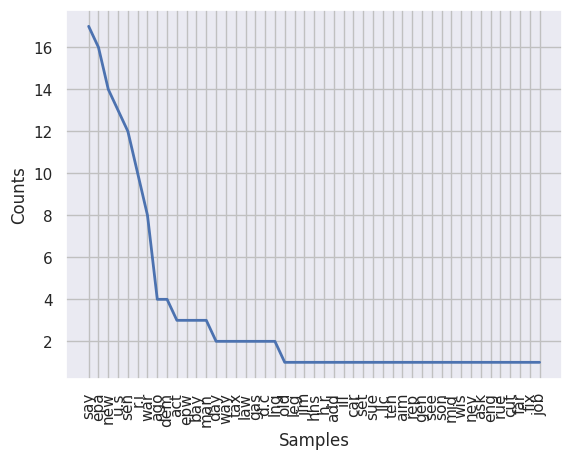

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution.

In [ ]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS).

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [ ]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [ ]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [ ]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 126, 'NNP': 39, 'NN': 1})),
 ('whitehouse', FreqDist({'NN': 21, 'NNP': 19})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [ ]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [ ]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 11, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'general': 5, 'potential': 5, 'fiscal': 5, 'last': 4, ...})

Or look at the most common nouns

In [ ]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 21),
 ('rhode', 19),
 ('island', 15),
 ('today', 15),
 ('stem', 12)]

Or plot the base form verbs against their number of occurrences

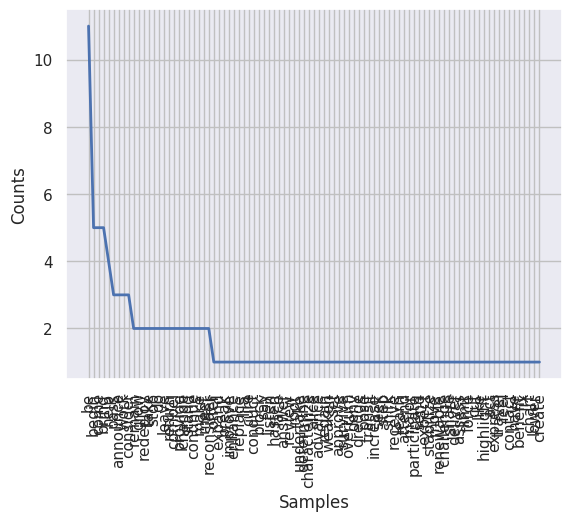

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [ ]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025190392501464556


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

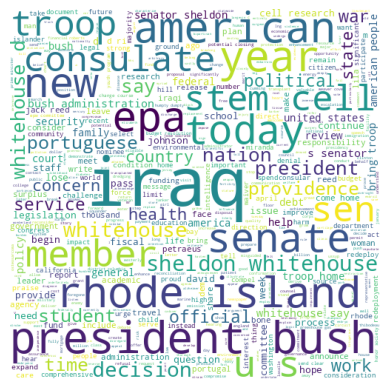

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

# <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</font>

- Continue working on the character dialogue df created above
- use SpaCy to remove stop words

In [29]:
nltk_texts_by_character

,Character,Dialogue,NLTK_Text
0,'Deathless Black Snake',"[ Amiya, oh Amiya. Do you know why you are so ...","(Amiya, ,, oh, Amiya, ., Do, you, know, why, y..."
1,'Emperors' Blade',"[ *Hiss*., You didn't tell them who you rea...","(*, Hiss, *, ., You, did, n't, tell, them, who..."
2,'Golding',"[Don't get the wrong idea, Golding. We don't a...","(Do, n't, get, the, wrong, idea, ,, Golding, ...."
3,'Iberian',"[Patience, Banshee. These were the most unforg...","(Patience, ,, Banshee, ., These, were, the, mo..."
4,'Kazimierzian',[I often feel that the times change with irreg...,"(I, often, feel, that, the, times, change, wit..."
...,...,...,...
360,Young Man's Voice,[ ...Damn it... Why... Even though we're all...,"(..., Damn, it, ..., Why, ..., Even, though, w..."
361,Young Soldier,"[Yes, Captain!, Yes, I suppose it went rather ...","(Yes, ,, Captain, !, Yes, ,, I, suppose, it, w..."
362,Young Ursus Student,"[Hello, are you here to listen in on Miss Kosh...","(Hello, ,, are, you, here, to, listen, in, on,..."
363,Young Volunteer,"[But I washed them already..., Jane, look, I k...","(But, I, washed, them, already, ..., Jane, ,, ..."


In [14]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [55]:
nltk_texts_by_character['normalized_tokens'] = nltk_texts_by_character['Dialogue'].apply(lambda x: normalizeTokens(x))

nltk_texts_by_character['normalized_tokens_count'] = nltk_texts_by_character['normalized_tokens'].apply(lambda x: len(x))

nltk_texts_by_character

,Character,Dialogue,NLTK_Text,normalized_tokens,normalized_tokens_count
0,'Deathless Black Snake',"[ Amiya, oh Amiya. Do you know why you are so ...","(Amiya, ,, oh, Amiya, ., Do, you, know, why, y...","[amiya, oh, amiya, know, shortsighted, weak, s...",442
1,'Emperors' Blade',"[ *Hiss*., You didn't tell them who you rea...","(*, Hiss, *, ., You, did, n't, tell, them, who...","[hiss, tell, plan, turn, exist, trust, place, ...",605
2,'Golding',"[Don't get the wrong idea, Golding. We don't a...","(Do, n't, get, the, wrong, idea, ,, Golding, ....","[wrong, idea, golde, actually, like, job, will...",24
3,'Iberian',"[Patience, Banshee. These were the most unforg...","(Patience, ,, Banshee, ., These, were, the, mo...","[patience, banshee, unforgettable, day, certai...",176
4,'Kazimierzian',[I often feel that the times change with irreg...,"(I, often, feel, that, the, times, change, wit...","[feel, time, change, irregularity, mean, come,...",118
...,...,...,...,...,...
360,Young Man's Voice,[ ...Damn it... Why... Even though we're all...,"(..., Damn, it, ..., Why, ..., Even, though, w...","[damn, infect, rhode, island]",4
361,Young Soldier,"[Yes, Captain!, Yes, I suppose it went rather ...","(Yes, ,, Captain, !, Yes, ,, I, suppose, it, w...","[yes, captain, yes, suppose, go, thank, haha, ...",79
362,Young Ursus Student,"[Hello, are you here to listen in on Miss Kosh...","(Hello, ,, are, you, here, to, listen, in, on,...","[hello, listen, miss, koshelna, lecture, right...",36
363,Young Volunteer,"[But I washed them already..., Jane, look, I k...","(But, I, washed, them, already, ..., Jane, ,, ...","[wash, jane, look, know, speak, sense, supply,...",27


In [56]:
Kaltsit_normalized_tokens = nltk_texts_by_character['normalized_tokens'].iloc[152]
amiya_normalized_tokens = nltk_texts_by_character['normalized_tokens'].iloc[29]

In [ ]:
kaltsit_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in Kaltsit_normalized_tokens))
#plot 4 letter words 
kaltsit_cfdist[4].plot() 

# to many words, a hard to see

In [59]:
kaltsit_cpdist = nltk.ConditionalProbDist(kaltsit_cfdist, nltk.ELEProbDist)

print(kaltsit_cpdist[5].max())
print(kaltsit_cpdist[5].prob(kaltsit_cpdist[4].max()))

amiya
0.00024073182474723158


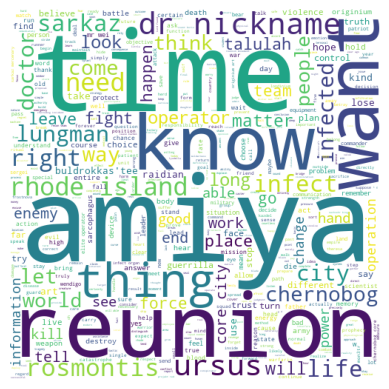

In [110]:
# word cloud for Kaltsit

wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(Kaltsit_normalized_tokens))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("Kaltsit_word_cloud.pdf", format = 'pdf')

plt.show()

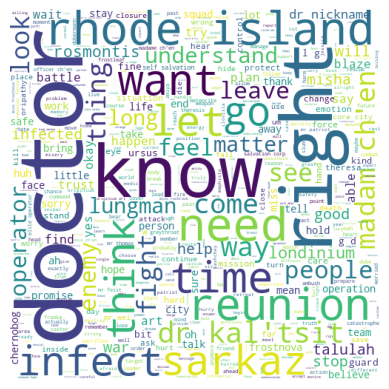

In [111]:
# word cloud for Amiya

wc2 = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(amiya_normalized_tokens))
plt.imshow(wc2)
plt.axis("off")
#plt.savefig("Amiya_word_cloud.pdf", format = 'pdf')

plt.show()

####
- Two characters seems to exposed to a similar set of events (e.g reunion, rhode island, sarkze, etc.)
- We can see the mention of name is not reciprocal between the two major characters: Kal'tsit mention Amiya by name very frequently, but not reverse
- Their relationship with "doctor" is different? (Note that both "doctor" and "dr nickname" refers to doctor, but Amiya use predominantly "doctor", while Kaltsit use "dr")

##### Try some conditional probability distribution with main dataframe

In [15]:
main_plots_df['normalized_tokens'] = main_plots_df['Dialogue'].apply(lambda x: normalizeTokens(x))

main_plots_df['normalized_tokens_count'] = main_plots_df['normalized_tokens'].apply(lambda x: len(x))

main_plots_df

,Story,Character,Dialogue,sentences,POS_sents,normalized_tokens,normalized_tokens_count
4,0. Evil Time Part 1,NaN,It's been a long time since we've last seen...,"[[It, 's, been, a, long, time, since, we, 've,...","[[(It, PRP), ('s, VBZ), (been, VBN), (a, DT), ...","[long, time, see]",3
5,0. Evil Time Part 1,NaN,During this time... you've been teetering o...,"[[During, this, time], [you, 've, been, teeter...","[[(During, IN), (this, DT), (time, NN), (you, ...","[time, teeter, edge, cliff]",4
7,0. Evil Time Part 1,NaN,"You may have forgotten who you are, but jus...","[[You, may, have, forgotten, who, you, are, bu...","[[(You, PRP), (may, MD), (have, VB), (forgotte...","[forget, remember]",2
9,0. Evil Time Part 1,NaN,...It's time. Don't linger here for too long.,"[[It, 's, time], [Do, n't, linger, here, for, ...","[[(It, PRP), ('s, VBZ), (time, NN), (Do, VB), ...","[time, linger, long]",3
10,0. Evil Time Part 1,NaN,"After all, you aren't my guest yet, nor sho...","[[After, all, you, are, n't, my, guest, yet, n...","[[(After, IN), (all, RB), (you, PRP), (are, VB...",[guest],1
...,...,...,...,...,...,...,...
49822,9. Stormwatch,Talulah,Looks like I need to get used to this weathe...,"[[Looks, like, I, need, to, get, used, to, thi...","[[(Looks, VBZ), (like, IN), (I, PRP), (need, V...","[look, like, need, weather]",4
49823,9. Stormwatch,Talulah,"Sorry, I can't take too long. I need to go n...","[[Sorry, I, ca, n't, take, too, long], [I, nee...","[[(Sorry, UH), (I, PRP), (ca, MD), (n't, RB), ...","[sorry, long, need, owe, explanation]",5
49824,9. Stormwatch,Talulah,"One day, we will make it through this snowst...","[[One, day, we, will, make, it, through, this,...","[[(One, CD), (day, NN), (we, PRP), (will, MD),...","[day, snowstorm, reach, end, ultimately, reach]",6
49826,9. Stormwatch,Talulah,"But, right now, it looks like this place nee...","[[But, right, now, it, looks, like, this, plac...","[[(But, CC), (right, RB), (now, RB), (it, PRP)...","[right, look, like, place, need, flame, awaken]",7


In [32]:
# give a list of unique story names
main_plots_df['Story'].unique()

array(['0. Evil Time Part 1', '10. Shatterpoint', '11. Return To Mist',
       '12. All Quiet Under the Thunder', '1. Evil Time Part 2',
       '2. Separated Hearts', '3. Stinging Shock', '4. Burning Run',
       '5. Necessary Solutions', '6. Partial Necrosis',
       '7. The Birth of Tragedy', '8. Roaring Flare', '9. Stormwatch'],
      dtype=object)

In [33]:
#whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

## compare the conditional frequency distribution of each story

# create a dictionary to store the conditional frequency and probability distribution of each story
story_cfdist = {}
story_cpdist = {}

for story in main_plots_df['Story'].unique():
    story_cfdist[story] = nltk.ConditionalFreqDist(((len(w), w) for w in main_plots_df[main_plots_df['Story'] == story]['normalized_tokens'].sum()))
    story_cpdist[story] = nltk.ConditionalProbDist(story_cfdist[story], nltk.ELEProbDist)


In [42]:
## how many unique, meaningful words in stories
len(main_plots_df[main_plots_df['Story'] == story]['normalized_tokens'].sum())

2777

In [53]:
story_cfdist['0. Evil Time Part 1'][4]

FreqDist({'time': 42, 'like': 29, 'team': 23, 'come': 22, 'need': 16, 'know': 15, 'plan': 13, 'able': 12, 'long': 11, 'find': 11, ...})

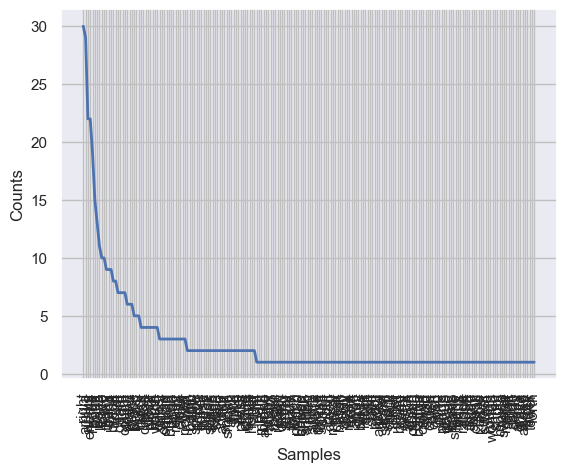

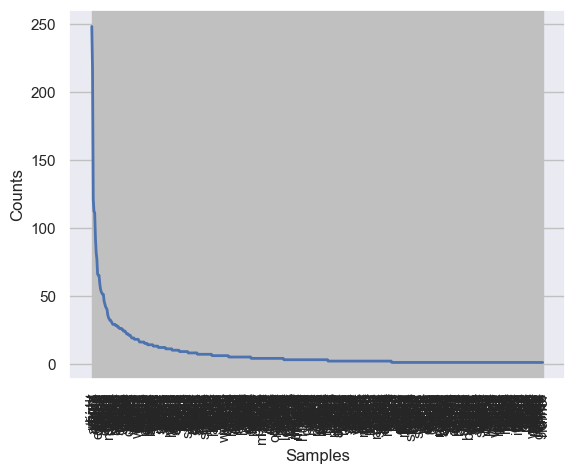

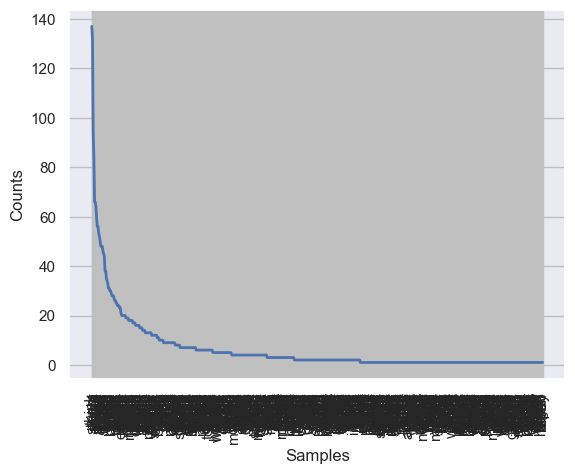

In [62]:
## sketch the conditional probability distribution for the first 3 stories on 5-letter words (just as experiment)

for story in main_plots_df['Story'].unique()[:3]:
    story_cfdist[story][5].plot()


- this get messy easily when the story is long
- I'll try to get the only the top 5-letter words

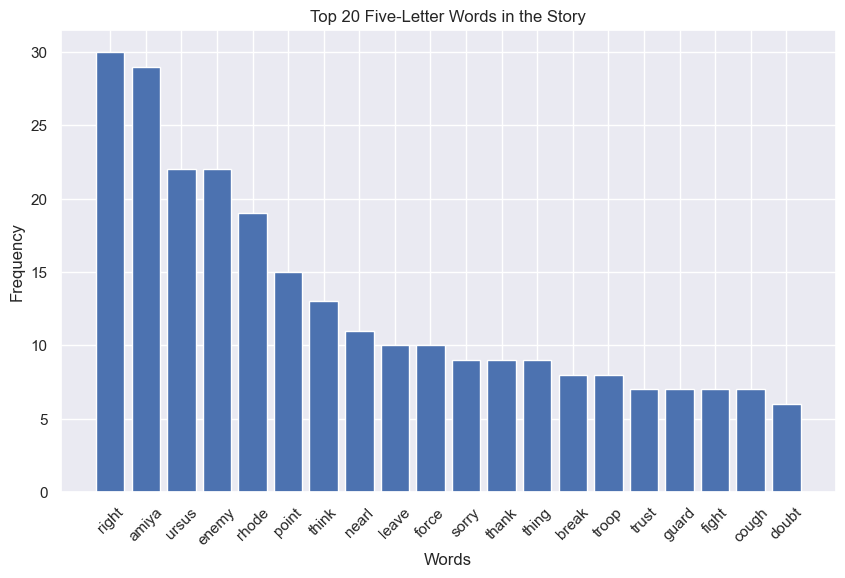

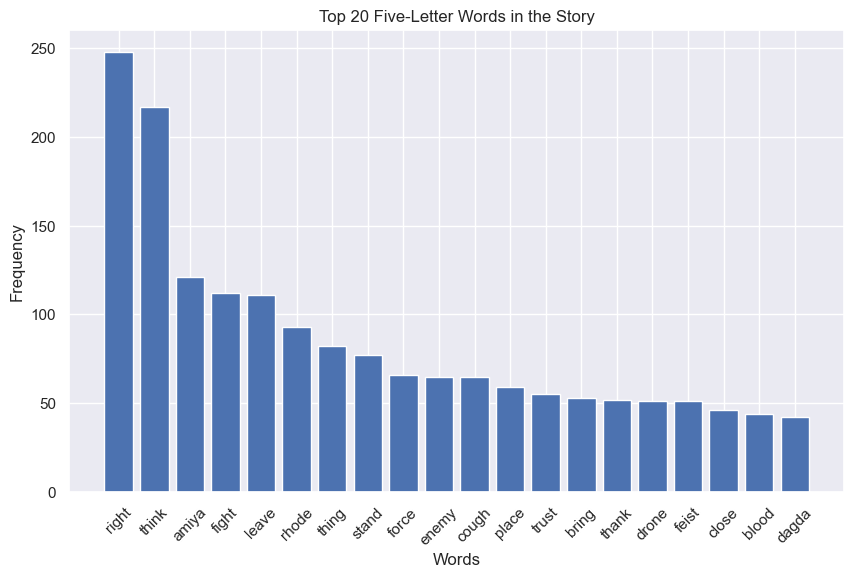

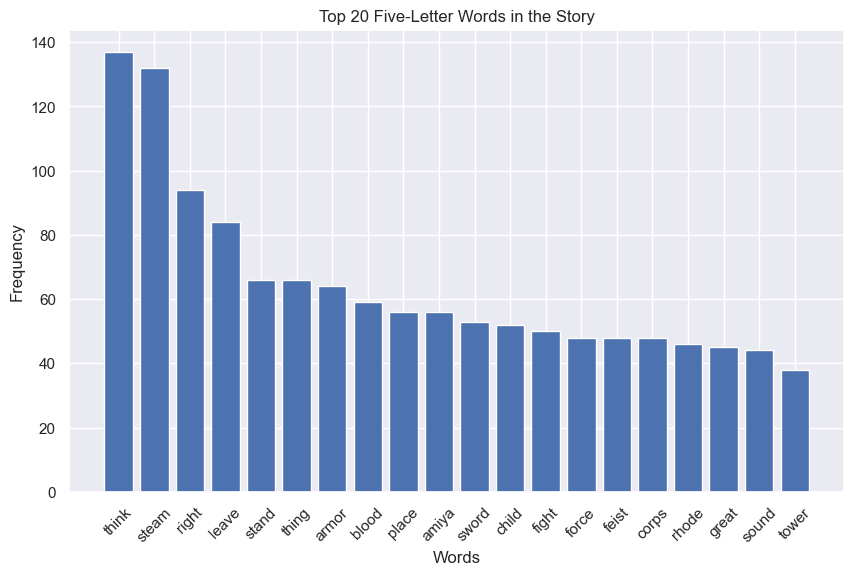

In [64]:
for story in main_plots_df['Story'].unique()[:3]:
    # Step 1: Sort the words by frequency
    sorted_words = sorted(story_cfdist[story][5].items(), key=lambda item: item[1], reverse=True)

    # Step 2: Select the top 20 words
    top_20_words = sorted_words[:20]

    # Step 3: Plot the frequencies
    words, frequencies = zip(*top_20_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Five-Letter Words in the Story')
    plt.xticks(rotation=45)
    plt.show()

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [ ]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

Note that in the following cells, we make use of the `lucem_illud` package's `word_tokenize` function. You can see that function on line 70 of [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py), and we provide the code here for transparency. Since we put this folder in our helper package, you won't need to define this function every time you want to use it; you just `import lucem_illud`!

In [ ]:
# processing.py calls a spacy model called "en" (and sometimes called "en_core_web_sm") so we load that first.
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):

    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])

    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
movie_texts = {}

In [ ]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        # We can run the following line of code with or without `lucem_illud.`, using the package or our code 2 cells above.
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [ ]:
import pandas as pd

In [ ]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [ ]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [ ]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,"[Tom, Lincoln, It, 's, a, comin, Boy, or, gal,..."
6930684,It's Tough to Be Famous,"Comedy, Drama",1932,English,"[music_continues, music_continues, music_ends,..."
6930686,The Midnight Lady,"Crime, Drama, Mystery",1932,English,"[@dramatic_orchestral_music, Woman, What, do, ..."
5848404,Young America,Drama,1932,English,"[Come, on, Come, on, Hurry, up, Hurry, up, Com..."
4193921,Blood Money,"Drama, Film-Noir, Romance",1933,English,"[This, program, has, come, to, you, from, Bill..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [ ]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA NOUN NN
to PART TO
get VERB VB
some PRON DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv')


Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in `lucem_illud`.



In [ ]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [ ]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, Hello, IT], [>, $, Usr, Hi, I, am,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [ ]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [ ]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [ ]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (So...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, NNP),...
1    [[(>, XX), ($, $), (Me, PRP)], [(Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [ ]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 22),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('job', 7),
 ('something', 7),
 ('problem', 7),
 ('drawer', 7)]

What about the adjectives that modify the word, "computer"?

In [ ]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'unrestricted', 'own'}


# <font color="red">Exercise 3</font>

<font color="red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [11]:
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):

    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])

    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [66]:
test_dialogue = nlp(main_plots_df['Dialogue'].iloc[100])

test_dialogue

   Curses... Are they after the Doctor?!

In [67]:
for token in test_dialogue:
    print(token.text, token.pos_, token.tag_)

    SPACE _SP
Curses PROPN NNPS
... PUNCT :
Are AUX VBP
they PRON PRP
after ADP IN
the DET DT
Doctor NOUN NN
? PUNCT .
! PUNCT .


In [8]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [9]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [12]:
## work on all dialogues in main plots

main_plots_df['sentences'] = main_plots_df['Dialogue'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
main_plots_df['POS_sents'] = main_plots_df['sentences'].apply(lambda x: tag_sents_pos(x))

c:\Users\Admin\anaconda3\envs\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [71]:
main_plots_df

,Story,Character,Dialogue,normalized_tokens,normalized_tokens_count,sentences,POS_sents
4,0. Evil Time Part 1,NaN,It's been a long time since we've last seen...,"[long, time, see]",3,"[[It, 's, been, a, long, time, since, we, 've,...","[[(It, PRP), ('s, VBZ), (been, VBN), (a, DT), ..."
5,0. Evil Time Part 1,NaN,During this time... you've been teetering o...,"[time, teeter, edge, cliff]",4,"[[During, this, time], [you, 've, been, teeter...","[[(During, IN), (this, DT), (time, NN), (you, ..."
7,0. Evil Time Part 1,NaN,"You may have forgotten who you are, but jus...","[forget, remember]",2,"[[You, may, have, forgotten, who, you, are, bu...","[[(You, PRP), (may, MD), (have, VB), (forgotte..."
9,0. Evil Time Part 1,NaN,...It's time. Don't linger here for too long.,"[time, linger, long]",3,"[[It, 's, time], [Do, n't, linger, here, for, ...","[[(It, PRP), ('s, VBZ), (time, NN), (Do, VB), ..."
10,0. Evil Time Part 1,NaN,"After all, you aren't my guest yet, nor sho...",[guest],1,"[[After, all, you, are, n't, my, guest, yet, n...","[[(After, IN), (all, RB), (you, PRP), (are, VB..."
...,...,...,...,...,...,...,...
49822,9. Stormwatch,Talulah,Looks like I need to get used to this weathe...,"[look, like, need, weather]",4,"[[Looks, like, I, need, to, get, used, to, thi...","[[(Looks, VBZ), (like, IN), (I, PRP), (need, V..."
49823,9. Stormwatch,Talulah,"Sorry, I can't take too long. I need to go n...","[sorry, long, need, owe, explanation]",5,"[[Sorry, I, ca, n't, take, too, long], [I, nee...","[[(Sorry, UH), (I, PRP), (ca, MD), (n't, RB), ..."
49824,9. Stormwatch,Talulah,"One day, we will make it through this snowst...","[day, snowstorm, reach, end, ultimately, reach]",6,"[[One, day, we, will, make, it, through, this,...","[[(One, CD), (day, NN), (we, PRP), (will, MD),..."
49826,9. Stormwatch,Talulah,"But, right now, it looks like this place nee...","[right, look, like, place, need, flame, awaken]",7,"[[But, right, now, it, looks, like, this, plac...","[[(But, CC), (right, RB), (now, RB), (it, PRP)..."


#### Let's compare the verb, adjective, and noun used by different characters

In [76]:
#
def count_character_pos(sentences, countTarget, dataframe, characterTarget):
    """
    function which counts the number of times a POS tag appears all sentences around a character.
    """
    targetCounts = {}
    for entry in dataframe[dataframe['Character'] == characterTarget][sentences]:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1

    sortedTargets = sorted(targetCounts.items(), key=lambda x: x[1], reverse=True)
    return sortedTargets

In [77]:
kaltsit_NN = count_character_pos('POS_sents', 'NN', main_plots_df, 'Kal\'tsit')
amiya_NN = count_character_pos('POS_sents', 'NN', main_plots_df, 'Amiya')


In [78]:
kaltsit_NN[:20]

[('time', 87),
 ('city', 69),
 ('Reunion', 58),
 ('world', 42),
 ('way', 39),
 ('core', 34),
 ('life', 33),
 ('something', 29),
 ('information', 26),
 ('thing', 25),
 ("Buldrokkas'tee", 24),
 ('place', 23),
 ('nothing', 23),
 ('Doctor', 23),
 ('one', 22),
 ('team', 22),
 ('power', 21),
 ('operation', 20),
 ('truth', 20),
 ('sarcophagus', 19)]

In [79]:
amiya_NN[:20]

[('Doctor', 149),
 ('time', 87),
 ('way', 74),
 ('Reunion', 72),
 ('city', 60),
 ('everyone', 43),
 ('war', 43),
 ('battle', 39),
 ('enemy', 39),
 ('everything', 33),
 ('person', 32),
 ('something', 31),
 ('team', 31),
 ('lot', 29),
 ('operation', 27),
 ('nothing', 26),
 ('bit', 25),
 ('Everyone', 25),
 ('thing', 25),
 ('plan', 24)]

In [81]:
kaltsit_JJ = count_character_pos('POS_sents', 'JJ', main_plots_df, 'Kal\'tsit')
amiya_JJ = count_character_pos('POS_sents', 'JJ', main_plots_df, 'Amiya')

In [82]:
kaltsit_JJ[:20]

[('other', 42),
 ('own', 40),
 ('able', 33),
 ('many', 24),
 ('same', 23),
 ('much', 22),
 ('different', 21),
 ('Infected', 21),
 ('entire', 18),
 ('right', 18),
 ('elite', 16),
 ('first', 15),
 ('next', 15),
 ('good', 15),
 ('certain', 14),
 ('sure', 14),
 ('last', 13),
 ('special', 13),
 ('few', 12),
 ('true', 12)]

In [83]:
amiya_JJ[:20]

[('other', 55),
 ('able', 51),
 ('right', 38),
 ('same', 37),
 ('many', 34),
 ('own', 33),
 ('good', 31),
 ('little', 28),
 ('fine', 26),
 ('much', 25),
 ('sure', 25),
 ('safe', 24),
 ('enough', 23),
 ('Infected', 21),
 ('sorry', 20),
 ('wrong', 16),
 ('okay', 15),
 ('last', 15),
 ('hard', 13),
 ('worried', 13)]

-- You can observer the differences among the use of words between the two characters. (e.g. more verbal words like "fine", "sorry", "okay" are found in Amiya's lines but not Kal'tsit's lines.)

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*).

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [ ]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [ ]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('u.s', 'senator'), ('whitehouse', 'say'), ('american', 'people')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [ ]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  13, The second word is: 13
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics.

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('u.s', 'senator'), 57.03786703770191),
 (('senator', 'sheldon'), 46.93608358543005),
 (('jack', 'reed'), 46.47304595760241),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.086787845859

There are a few other available measures

In [ ]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.448829313992519),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.235832851864714),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319807585174225),
 (('jack', 'reed', 'd'), 1.7319693830304341),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.731188665397125),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement', 'act'), 1.4142003635705542),
 (('select', 'committee'

Or n-grams (for any number n)

In [ ]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senator', 'jack', 'reed'): 2, ('senator', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [ ]:
import gensim

In [ ]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [ ]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [ ]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


# <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<font color="red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</font>

In [16]:
main_plots_df

,Story,Character,Dialogue,sentences,POS_sents,normalized_tokens,normalized_tokens_count
4,0. Evil Time Part 1,NaN,It's been a long time since we've last seen...,"[[It, 's, been, a, long, time, since, we, 've,...","[[(It, PRP), ('s, VBZ), (been, VBN), (a, DT), ...","[long, time, see]",3
5,0. Evil Time Part 1,NaN,During this time... you've been teetering o...,"[[During, this, time], [you, 've, been, teeter...","[[(During, IN), (this, DT), (time, NN), (you, ...","[time, teeter, edge, cliff]",4
7,0. Evil Time Part 1,NaN,"You may have forgotten who you are, but jus...","[[You, may, have, forgotten, who, you, are, bu...","[[(You, PRP), (may, MD), (have, VB), (forgotte...","[forget, remember]",2
9,0. Evil Time Part 1,NaN,...It's time. Don't linger here for too long.,"[[It, 's, time], [Do, n't, linger, here, for, ...","[[(It, PRP), ('s, VBZ), (time, NN), (Do, VB), ...","[time, linger, long]",3
10,0. Evil Time Part 1,NaN,"After all, you aren't my guest yet, nor sho...","[[After, all, you, are, n't, my, guest, yet, n...","[[(After, IN), (all, RB), (you, PRP), (are, VB...",[guest],1
...,...,...,...,...,...,...,...
49822,9. Stormwatch,Talulah,Looks like I need to get used to this weathe...,"[[Looks, like, I, need, to, get, used, to, thi...","[[(Looks, VBZ), (like, IN), (I, PRP), (need, V...","[look, like, need, weather]",4
49823,9. Stormwatch,Talulah,"Sorry, I can't take too long. I need to go n...","[[Sorry, I, ca, n't, take, too, long], [I, nee...","[[(Sorry, UH), (I, PRP), (ca, MD), (n't, RB), ...","[sorry, long, need, owe, explanation]",5
49824,9. Stormwatch,Talulah,"One day, we will make it through this snowst...","[[One, day, we, will, make, it, through, this,...","[[(One, CD), (day, NN), (we, PRP), (will, MD),...","[day, snowstorm, reach, end, ultimately, reach]",6
49826,9. Stormwatch,Talulah,"But, right now, it looks like this place nee...","[[But, right, now, it, looks, like, this, plac...","[[(But, CC), (right, RB), (now, RB), (it, PRP)...","[right, look, like, place, need, flame, awaken]",7


In [24]:
import nltk

In [19]:
amiya_df = main_plots_df[main_plots_df['Character'] == 'Amiya']

amiya_df

,Story,Character,Dialogue,sentences,POS_sents,normalized_tokens,normalized_tokens_count
51,0. Evil Time Part 1,Amiya,Ah... S-sorry.,"[[Ah, S, sorry]]","[[(Ah, UH), (S, NNP), (sorry, JJ)]]","[ah, s, sorry]",3
54,0. Evil Time Part 1,Amiya,...I'm already mentally prepared for that. ...,"[[I, 'm, already, mentally, prepared, for, tha...","[[(I, PRP), (', VBP), (m, VBP), (already, RB),...","[mentally, prepare, continue, follow, plan]",5
56,0. Evil Time Part 1,Amiya,All right... I appreciate it.,"[[All, right], [I, appreciate, it]]","[[(All, RB), (right, RB), (I, PRP), (appreciat...","[right, appreciate]",2
57,0. Evil Time Part 1,Amiya,About the Doctor...,"[[About, the, Doctor]]","[[(About, IN), (the, DT), (Doctor, NN)]]",[doctor],1
60,0. Evil Time Part 1,Amiya,Thank you... Thank you very much!,"[[Thank, you], [Thank, you, very, much]]","[[(Thank, VBP), (you, PRP), (Thank, VBP), (you...","[thank, thank]",2
...,...,...,...,...,...,...,...
49688,9. Stormwatch,Amiya,"It's strange... Dr. Kal'tsit, Closure, Docto...","[[It, 's, strange, Dr., Kal'tsit, Closure, Doc...","[[(It, PRP), ('s, VBZ), (strange, JJ), (Dr., N...","[strange, dr, kal'tsit, closure, doctor, get, ...",10
49696,9. Stormwatch,Amiya,"Maybe... certain things are fated to happen,...","[[Maybe, certain, things, are, fated, to, happ...","[[(Maybe, RB), (certain, JJ), (things, NNS), (...","[maybe, certain, thing, fate, happen, soon, la...",8
49697,9. Stormwatch,Amiya,I think...,"[[I, think]]","[[(I, PRP), (think, VBP)]]",[think],1
49698,9. Stormwatch,Amiya,...this isn't the end.,"[[this, is, n't, the, end]]","[[(this, DT), (is, VBZ), (n't, RB), (the, DT),...",[end],1


In [26]:
# find bigrams for e.g. amiya

amiya_bigram = nltk.collocations.BigramCollocationFinder.from_words(amiya_df['normalized_tokens'].sum())

print("There are {} bigrams in the finder".format(amiya_bigram.N))


There are 13480 bigrams in the finder


In [27]:
def bigramScoring(count, wordsTuple, total):
    return count
print(amiya_bigram.nbest(bigramScoring, 10))

[('rhode', 'island'), ('dr', "kal'tsit"), ('madam', "ch'en"), ('dr', '@nickname'), ('core', 'city'), ('mr', 'wei'), ('self', 'salvation'), ('madame', "ch'en"), ('mr', 'feist'), ('doctor', 'doctor')]


In [29]:
# this measure can see more clearly the bigrams that are more meaningful

bigram_measures = nltk.collocations.BigramAssocMeasures()
amiya_bigram.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('rhode', 'island'), 1293.6071818900618),
 (('dr', "kal'tsit"), 839.5888964811372),
 (('madam', "ch'en"), 750.5545960807488),
 (('dr', '@nickname'), 417.9862881104605),
 (('self', 'salvation'), 279.48448666096164),
 (('core', 'city'), 193.7048318715985),
 (('mr', 'wei'), 187.37407703344905),
 (('madame', "ch'en"), 163.96860933946135),
 (('salvation', 'corps'), 154.16530526082855),
 (('mr', 'feist'), 153.33273992031374),
 (('elite', 'operator'), 139.33899151819503),
 (('mr', 'thomas'), 138.5299781145295),
 (('l.', 'g.'), 134.86758477060198),
 (('g.', 'd.'), 113.85077307144107),
 (('officer', "ch'en"), 113.15586566440925),
 (('lady', 'heidi'), 94.04523052084494),
 (('salvation', 'corp'), 93.98123009015876),
 (('command', 'tower'), 89.64380693965641),
 (('chi', 'xiao'), 88.99338989156989),
 (('miss', 'rockrock'), 88.50611054290485),
 (('mr', 'patriot'), 85.14259529504135),
 (('penguin', 'logistic'), 78.18006931279945),
 (('rhodes', 'island'), 75.2771802596038),
 (('originium', 'art'), 7

There are many bigrams clearly name and location in the plot; this make sense in a drama-like presentation

Among the bigrams, we can see "reunion" + "movement" and "reunion" + "force" combo. Let's examine whether the use of word "reunion" is idiomatic/irreducible


Here is another approach using nltk.util copied from online

In [22]:
from nltk.util import ngrams, skipgrams
from collections import Counter

# Assuming df["normalized_tokens"] is a list of lists of tokens
tokens = sum(amiya_df["normalized_tokens"], [])

# Bigrams, Trigrams, and N-grams
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))
# For other n-grams, change the 3 to any n you want

# Skip-grams (example with n=2, k=2)
skip_grams = list(skipgrams(tokens, 2, 2))

# Frequency analysis
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)
skipgram_freq = Counter(skip_grams)

# Get the most common elements
top_bigrams = bigram_freq.most_common(20)
top_trigrams = trigram_freq.most_common(20)
top_skipgrams = skipgram_freq.most_common(20)

# You can then print these or analyze further
print("Top Bigrams:", top_bigrams)
print("Top Trigrams:", top_trigrams)
print("Top Skipgrams:", top_skipgrams)


Top Bigrams: [(('rhode', 'island'), 118), (('dr', "kal'tsit"), 86), (('madam', "ch'en"), 77), (('dr', '@nickname'), 45), (('core', 'city'), 20), (('mr', 'wei'), 20), (('self', 'salvation'), 19), (('mr', 'feist'), 17), (('madame', "ch'en"), 17), (('doctor', 'doctor'), 13), (('elite', 'operator'), 13), (('mr', 'thomas'), 13), (('look', 'like'), 13), (('officer', "ch'en"), 13), (('reunion', 'force'), 12), (('salvation', 'corps'), 12), (('mr', 'patriot'), 11), (('miss', 'rockrock'), 10), (('island', 'fight'), 10), (('miss', 'frostnova'), 10)]
Top Trigrams: [(('self', 'salvation', 'corps'), 12), (('rhode', 'island', 'fight'), 10), (("ch'en", 'madam', "ch'en"), 9), (('madam', "ch'en", 'madam'), 8), (('self', 'salvation', 'corp'), 7), (('l.', 'g.', 'd.'), 7), (('dr', "kal'tsit", 'right'), 6), (('chernobog', 'core', 'city'), 4), (('dr', "kal'tsit", 'dr'), 4), (('let', 'rhode', 'island'), 4), (('plan', 'mr', 'wei'), 4), (('rhode', 'island', 'operator'), 4), (('mr', 'patriot', 'mr'), 4), (('patr

In [32]:
cfdist = nltk.probability.ConditionalFreqDist((word, bigram[1]) for bigram in bigrams for word in [bigram[0]])

reunion_collocations = cfdist['reunion'].most_common()


In [33]:
for word, frequency in reunion_collocations:
    print(f"'reunion {word}' appears {frequency} times")


'reunion force' appears 12 times
'reunion movement' appears 6 times
'reunion member' appears 5 times
'reunion attack' appears 4 times
'reunion unit' appears 3 times
'reunion take' appears 2 times
'reunion leader' appears 2 times
'reunion troop' appears 2 times
'reunion manage' appears 2 times
'reunion reunion' appears 2 times
'reunion rescue' appears 2 times
'reunion infect' appears 2 times
'reunion squad' appears 2 times
'reunion rhode' appears 2 times
'reunion main' appears 2 times
'reunion shhhh' appears 1 times
'reunion disband' appears 1 times
'reunion terrible' appears 1 times
'reunion haze' appears 1 times
'reunion enslave' appears 1 times
'reunion able' appears 1 times
'reunion fight' appears 1 times
'reunion proposal' appears 1 times
'reunion organization' appears 1 times
'reunion go' appears 1 times
'reunion dr' appears 1 times
'reunion badge' appears 1 times
'reunion infiltrate' appears 1 times
'reunion infected' appears 1 times
'reunion will' appears 1 times
'reunion fact' 

- Looks like the term "reunion" appear very frequently as the **object** of acting something; (which is not the everyday use when we merely refering to a group of people gathering together)
- The verbs and adjectives in the bigrams that has "reunion" are often related to violent or distaste, which infer Amiya's (where all the text are collected from) stance towards the group.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects.
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
Swedish NORP


In [ ]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

We can also run NER over our entire corpus:

In [ ]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [ ]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Help Desk, PERSON)], [],...
8    [[(First, ORDINAL)], [(today, DATE)], [(Citrix...
7    [[], [(about a month, DATE), (a few days ago, ...
6    [[(all-employees@org.edu, NORP), (30,000, CARD...
5    [[(Helpdesk, ORG), (UK, GPE)], [(one, CARDINAL...
4    [[], [(Engineer, ORG), (All good 10 minutes la...
3    [[(the out of hours, TIME), (Desk Caller, PERS...
2    [[(1](http://www.reddit.com, CARDINAL), (comme...
1    [[], [], [(Usr, PERSON)], [], [], [], [], [(Us...
0    [[], [(over 45 minutes, TIME), (Smith, PERSON)...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3)]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'Edit 2',
 'all-employees@org.edu',
 '30k',
 'Caller',
 'last week',
 'three',
 'Usr Ca',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3),
 ('each day', 3)]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Non
HDD
Computer C O M P
Genius p
CAPITAL P. NUMBER FOUR LOWER
WeltallPrime
Fair
Milestone
all-employees@org.edu IT Fail 2
Helpdesk
Engineer
Google Bing
Google Bing
Google Bing
the Bing Search
Google Chrome
Google Bing
Caller
XYZ
Boss Wife 's
Bing
Buzzfeed
Boss 's
TodaysDate


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

#### This is an interesting topic around my corpus -- many names and relationship can be found in drama-like plots, and many are original to this story. Let's experiment how they'll be tagged.
- might be useful for future network analysis

In [35]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

In [36]:
# similarly, let's explore the named entities in the dialogues of Amiya
amiya_df['classified_sents'] = amiya_df['sentences'].apply(lambda x: tag_sents_ner(x))

amiya_df['classified_sents']

C:\Users\Admin\AppData\Local\Temp\ipykernel_30032\3098603310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amiya_df['classified_sents'] = amiya_df['sentences'].apply(lambda x: tag_sents_ner(x))


51                        [[]]
54                        [[]]
56                        [[]]
57                        [[]]
60                        [[]]
                 ...          
49688                     [[]]
49696                     [[]]
49697                     [[]]
49698                     [[]]
49699    [[(Talulah, PERSON)]]
Name: classified_sents, Length: 3698, dtype: object

In [40]:
## many lines are empty as "[[]]"

entityCounts = {}

for entry in amiya_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1

sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:25]



[('Rhodes Island', 99),
 ("Ch'en", 85),
 ('Reunion', 82),
 ('Sarkaz', 81),
 ('Infected', 47),
 ('Talulah', 44),
 ('Misha', 43),
 ('Londinium', 38),
 ('Lungmen', 35),
 ('FrostNova', 35),
 ('first', 29),
 ('one', 29),
 ('Feist', 23),
 ('two', 21),
 ('Wei', 21),
 ('Ursus', 19),
 ('Arts', 19),
 ('Patriot', 19),
 ('L.G.D.', 16),
 ("Rhodes Island 's", 15),
 ('Theresis', 13),
 ('Rosmontis', 13),
 ('Dublinn', 13),
 ('Thomas', 13),
 ('Theresa', 13)]

I'll leave the precision/recall/f1-score calculation for later. Here I'll just provide a basic plan for doing that, e.g. on Amiya's data
- Precision measures the accuracy of the entities identified; need to go through the result and check
- Recall: This measures the  ability to identify all relevant entities; need to generate a list of relevant entities (e.g. names, organization) and compare with
- f1 = 2 * (Precision * Recall) / (Precision + Recall).

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction.

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [41]:
from spacy import displacy

In [ ]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [ ]:
displacy.render(doc, style='dep')

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="8552363d86764c54a286923ce36c8c31-0" class="displacy" width="1275" height="399.5" direction="ltr" style="max-width: none; height: 399.5px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="50">Autonomous</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">ADJ</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="225">cars</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="400">shift</tspan>\n    <tspan class="disp

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [ ]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [ ]:
from spacy.symbols import nsubj, VERB

In [ ]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [ ]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [ ]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [ ]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [ ]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [ ]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must AUX aux submit
submit VERB ROOT submit
their PRON poss requests
requests NOUN dobj submit


In [ ]:
displacy.render(doc, style='dep')

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="8dd8c1dc75a9433999fa705df70753ec-0" class="displacy" width="925" height="312.0" direction="ltr" style="max-width: none; height: 312.0px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="50">Credit and mortgage account holders</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="225">must</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">AUX</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="400">submit</tspan

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset.

How violent are the movies? Who is killing who?

In [ ]:
movie_violences = {}

In [ ]:
from tqdm import tqdm
tqdm.pandas()

for index, row in movie_df[0:100].iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-110-841b0cdf717e>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if subject is not 0:
<ipython-input-110-841b0cdf717e>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if object_ is not 0:


In [ ]:
movie_violences

{'Abraham Lincoln': ([], ['her', 'glory']),
 "It's Tough to Be Famous": (['you'], ['yourself']),
 'The Midnight Lady': (['I'], ['him']),
 'Young America': ([], []),
 'Blood Money': ([], []),
 'Meet the Baron': ([], ['man']),
 'The Organ Grinder': (['she'], ['him']),
 "It's a Gift": (['That'], ['anybody']),
 'Looking for Trouble': (['I'], ['him']),
 'Riptide': ([], []),
 'Twentieth Century': (['I', 'He'], ['myself', 'himself']),
 "Goin' to Town": ([], ['horse']),
 'If You Could Only Cook': ([], ['him']),
 'Red Salute': (['I'], ['myself']),
 'Poor Little Rich Girl': (['we'], ['people', 'them']),
 'Poppy': ([], []),
 'Satan Met a Lady': (['you',
   'you',
   'Farrow',
   'I',
   'I',
   'I',
   'I',
   'I',
   'you',
   'you',
   'I'],
  ['him', 'him', 'partner', 'you', 'you', 'you', 'you', 'him', 'him', 'Ames']),
 'The Edge of the World': ([], []),
 'The Last Gangster': ([], []),
 'The Last of Mrs. Cheyney': ([], ['ass', 'Cheyney']),
 'Marie Antoinette': ([], []),
 'The Cowboy and the La

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

### <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

#### It might not be a good idea to analyze the *complex* structure -- the corpus are made of dialogues, rather short segments; even long speech are dissected into portions.

In [4]:
file_path = 'D://MACSS PROGRAM/30122/MACS-60000-2024-Winter/data/Arknights_plot'
files = list_files(file_path)
main_stories, side_stories = categorize_files(files)

all_data = {'main_stories': {}, 'side_stories': {}}
for story in main_stories:
    dfs = read_xlsx(os.path.join(file_path, story))
    all_data['main_stories'][story] = extract_dialogues(dfs)

for story in side_stories:
    dfs = read_xlsx(os.path.join(file_path, story))
    all_data['side_stories'][story] = extract_dialogues(dfs)

In [5]:
main_plots_df = pd.DataFrame(columns=['Story', 'Character', 'Dialogue'])

for story_name, scenes in all_data['main_stories'].items():
    for scene in scenes:
        # Extract characters and dialogues
        characters = scene['characters']
        dialogues = scene['dialogues']

        # Create a DataFrame for the current story
        story_df = pd.DataFrame({
            'Story': story_name,
            'Character': characters,
            'Dialogue': dialogues
        })

        # Append this DataFrame to the main DataFrame
        main_plots_df = pd.concat([main_plots_df, story_df], ignore_index=True)

In [23]:
from spacy import displacy
from spacy.symbols import nsubj, VERB
nlp = spacy.load("en_core_web_sm")


In [29]:
# let's extract 5 dialogues from Kal'tsit that are long enough

kaltsit_df = main_plots_df[main_plots_df['Character'] == 'Kal\'tsit']

# iterate over each dialogue and find some lengthy ones (still not so long as it is dialogue)
kal_speeches= []
for dialogue in kaltsit_df['Dialogue']:
    doc = nlp(dialogue)
    if len(doc) > 45:
        kal_speeches.append(dialogue)

In [30]:
kal_speeches

['If a Vampire establishes his own country, how would it be any different from the arrogant Victoria of today? If a Nachzehrer were to rule all civilization, how would the culture be any different from those under the ice-cold rule of Ursus?',
 "  You can't rely entirely on emotions, Amiya. There is more to feel than feelings alone. When you run your fingers through a head of hair, the first thing you feel is neither longing nor joy. It's something more base than that.",
 " Amiya, we are going over a form of violence. You have said as much to me. If you didn't want me to stop you here and now, then you wouldn't have asked me to swear it to you.",
 ' Even Patriot, seeing through to her scheme, had no power to reverse the tide in the middle of its change. If he could have killed Talulah, all the same, he still would have been unable to alter Reunion tending towards collapse.',
 " Or perhaps, even this is one of the weights on Talulah's scales, used to swindle the Ursus military out of th

In [24]:
displacy.render(nlp(kal_speeches[0]), style='dep')

- let me try to see the depth of those sentences

In [31]:
def calculate_depth(token, current_depth=0):
    if not list(token.children):
        return current_depth
    return max(calculate_depth(child, current_depth + 1) for child in token.children)

In [32]:
kal_depths = []
for sentence in kal_speeches:
    doc = nlp(sentence)
    root = [token for token in doc if token.head == token][0]  # Finding the root of the sentence
    depth = calculate_depth(root)
    kal_depths.append(depth)

In [27]:
print(kal_depths)

[5, 3, 4, 7, 8, 3, 5, 4, 3, 4, 4, 13, 6, 5, 4, 2, 5, 6, 2, 3, 4, 7, 5]


- we can compare this depth list with another character

In [34]:
amiya_df = main_plots_df[main_plots_df['Character'] == 'Amiya']
amiya_speechs = []
for dialogue in amiya_df['Dialogue']:
    doc = nlp(dialogue)
    if len(doc) > 45:
        amiya_speechs.append(dialogue)

amiya_depths = []
for sentence in amiya_speechs:
    doc = nlp(sentence)
    root = [token for token in doc if token.head == token][0]  # Finding the root of the sentence
    depth = calculate_depth(root)
    amiya_depths.append(depth)

print(amiya_depths)

[6, 4, 0, 4, 6, 3, 3]


- The most significant finding is that Kaltsit tend to speak longer and more complex sentence 
- Even Amiya has more dialogues, but she only has 7 lengthy sentences and with lower depths.

#### Let's take a look around the word "reunion" --- something special to this corpus

In [44]:
keywords = ["reunion"]

filtered_sentences = main_plots_df[main_plots_df['Dialogue'].str.contains('|'.join(keywords), case = False ,na = False)]



In [67]:
def extract_svo(sentence):
    doc = nlp(sentence)
    for token in doc:
        if token.lemma_ == 'reunion': #token.pos_ == 'VERB' and
            subject = [w for w in token.head.lefts if w.dep_ in ('subj', 'nsubj', 'nsubjpass')]
            object = [w for w in token.head.rights if w.dep_ in ('obj', 'dobj')]
            if subject and object:
                return subject[0], token, object[0]
            else:
                pass
                # Print for debugging
                # print(f"No SVO found in: {sentence}")
                # print(f"Subjects found: {[w.text for w in subject]}")
                # print(f"Objects found: {[w.text for w in object]}")
            
    return None, None, None

In [46]:
filtered_sentences

,Story,Character,Dialogue
139,main_0_Evil Time Part 1.xlsx,Amiya,These outfits... are they from the Reunion ...
202,main_0_Evil Time Part 1.xlsx,Dobermann,It's an emergency. My team was attacked by ...
204,main_0_Evil Time Part 1.xlsx,Amiya,Why would Reunion attack us...?
287,main_0_Evil Time Part 1.xlsx,Amiya,What's going on...? ! Why... Why is Reunion ...
293,main_0_Evil Time Part 1.xlsx,Dobermann,It's possible that Reunion's attack has alre...
...,...,...,...
49655,main_9_Stormwatch.xlsx,Talulah,"When did you join Reunion, Lungmenite?"
49673,main_9_Stormwatch.xlsx,Kal'tsit,Reunion has been tracking our ship under cov...
49736,main_9_Stormwatch.xlsx,Reunion Warrior,Of course she is! She's a Lungmenite who joi...
49748,main_9_Stormwatch.xlsx,Nine,"Just as you said, you don't have the right t..."


In [55]:
for sentence in filtered_sentences['Dialogue']:
    doc = nlp(sentence)
    subject, verb, object = extract_svo(sentence)
    if subject and object:
        print(f"{subject.text:<12} {verb.text:<10} {object.text:<12}")
        displacy.render(doc, style='dep')

Reunion      Reunion    us          


Reunion      Reunion    that        


- The package is misclassifying role for Reunion in some sentences (as verb when noun)

In [68]:
relationships = []
for sentence in filtered_sentences['Dialogue']:
    subj, verb, obj = extract_svo(sentence)
    if subj and verb and obj:
        relationships.append({'subject': subj.text, 'action': verb.lemma_, 'object': obj.text})


In [64]:
relationships

[{'subject': 'Reunion', 'action': 'reunion', 'object': 'us'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'place'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'advantage'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'them'},
 {'subject': 'We', 'action': 'reunion', 'object': 'reunion'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'them'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Catastrophe'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Infected'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Lungmen'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'damage'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Lungmen'},
 {'subject': 'who', 'action': 'reunion', 'object': 'themselves'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Chernobog'},
 {'subject': 'Reunion', 'action': 'reunion', 'object': 'Infected'},
 {'subject': 'They', 'action': 'reunion', 'object': 'Reunion'},
 {'subje

- Looks like most tagging are wrong; we need some custom POS tagging for "reunion" in this corpus....

In [81]:
target_words = ["originium", "oripathy"]

filtered_sentences = main_plots_df[main_plots_df['Dialogue'].str.contains('|'.join(keywords), case = False ,na = False)]

In [79]:
filtered_sentences

,Story,Character,Dialogue
390,main_0_Evil Time Part 1.xlsx,Amiya,'Oripathy.'
391,main_0_Evil Time Part 1.xlsx,Dobermann,Those who have contracted Oripathy are calle...
407,main_0_Evil Time Part 1.xlsx,Dobermann,Both Kal'tsit and Amiya have mentioned that ...
686,main_0_Evil Time Part 1.xlsx,Dobermann,...and turn into Originium-filled ruins.
1253,main_10_Shatterpoint.xlsx,Warfarin,"I mean, when you invited me to join Rhodes Is..."
...,...,...,...
48621,main_9_Stormwatch.xlsx,NaN,'They blanketed our city in a mist of Oripathy...
49117,main_9_Stormwatch.xlsx,Logistics Operator,Should I turn in the environmental Originium...
49182,main_9_Stormwatch.xlsx,NaN,There was this one time I mentioned a friend o...
49207,main_9_Stormwatch.xlsx,NaN,He didn't even know how he caught Oripathy. He...


In [84]:
from collections import Counter
word_roles = {word: [] for word in target_words}
co_occurrences = {word: Counter() for word in target_words}

for sentence in filtered_sentences["Dialogue"]:
    doc = nlp(sentence)
    for token in doc:
        if token.text.lower() in target_words:
            # Dependency Parsing
            word_roles[token.text.lower()].append(token.dep_)

            # Co-occurrence Analysis
            for neighbor in token.sent:
                if neighbor.text.lower() != token.text.lower():
                    co_occurrences[token.text.lower()][neighbor.text.lower()] += 1



In [85]:
print("Word Roles in Sentences:")
for word, roles in word_roles.items():
    print(f"{word}: {Counter(roles)}")

print("\nCo-occurring Words:")
for word, co_occurs in co_occurrences.items():
    print(f"{word}: {co_occurs.most_common(5)}")

Word Roles in Sentences:
originium: Counter({'compound': 124, 'pobj': 18, 'nsubj': 15, 'dobj': 11, 'npadvmod': 4, 'ROOT': 2, 'attr': 2, 'conj': 1})
oripathy: Counter({'dobj': 27, 'pobj': 21, 'compound': 14, 'nsubj': 7, 'ROOT': 2, 'amod': 2, 'attr': 1, 'appos': 1, 'advmod': 1, 'npadvmod': 1, 'poss': 1})

Co-occurring Words:
originium: [('the', 156), ('.', 116), (',', 92), ('of', 67), ('  ', 50)]
oripathy: [(',', 70), ('.', 56), ('the', 37), ('  ', 30), ('of', 24)]


Doesn't seem working again -- when the words are special objects in the corpus, even NOUNS need extra handling

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the:

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$.

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [ ]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [ ]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [ ]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

260

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [ ]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [ ]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6369388336069717
0.5818824611674388


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [ ]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,high,0.001185
1,american,0.025754
2,tell,0.002116
3,participate,0.000004
4,fully,0.000811
5,stand,0.000811
6,chairman,0.004994
7,agency,0.000110
8,thousand,0.003776
9,clinton,0.000811


In [ ]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
197,iraq,0.094524
110,bush,0.047893
1,american,0.025754
257,stem,0.023613
251,law,0.022835
140,department,0.018926
147,member,0.013172
208,war,0.012601
151,program,0.011258
12,country,0.010142


Now we will apply what we learned today
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [ ]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [ ]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [ ]:
len(corpora)

11

In [ ]:
fileids = list(movie_df['Movie Name'])[0:11]

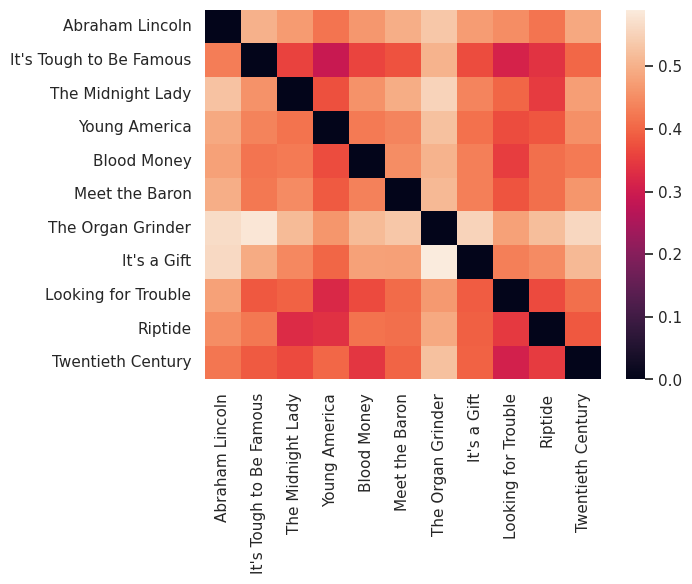

In [ ]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


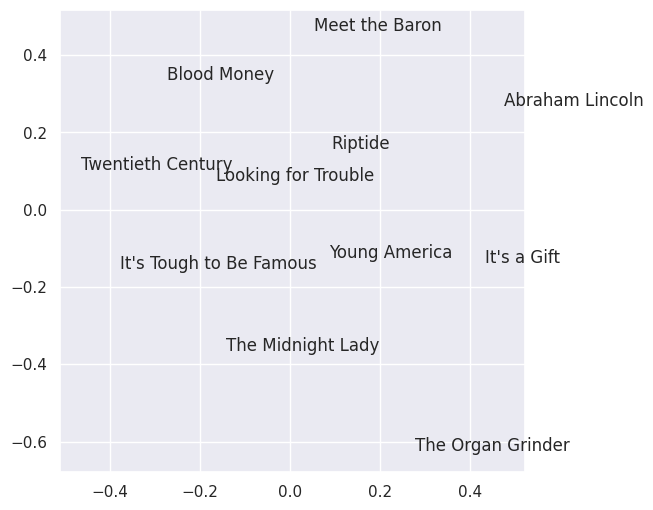

In [ ]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

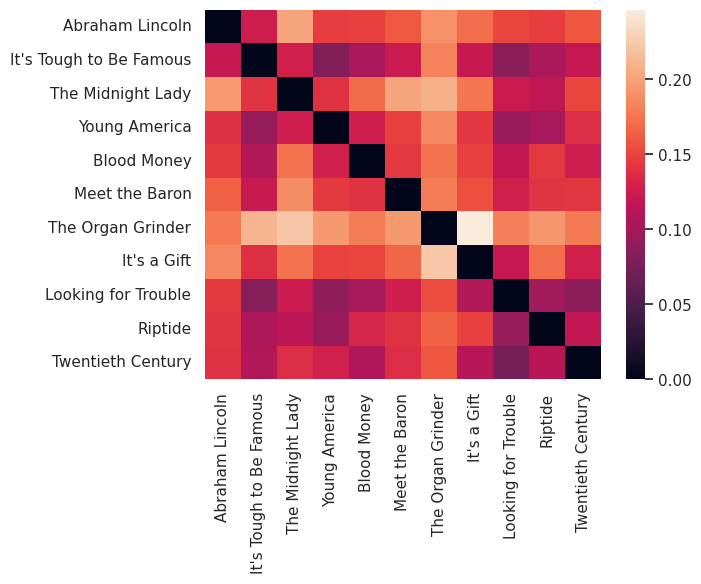

In [ ]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

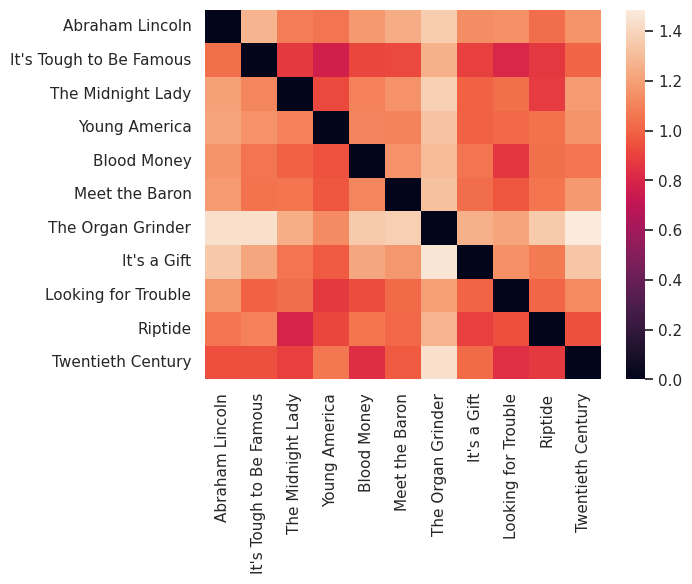

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

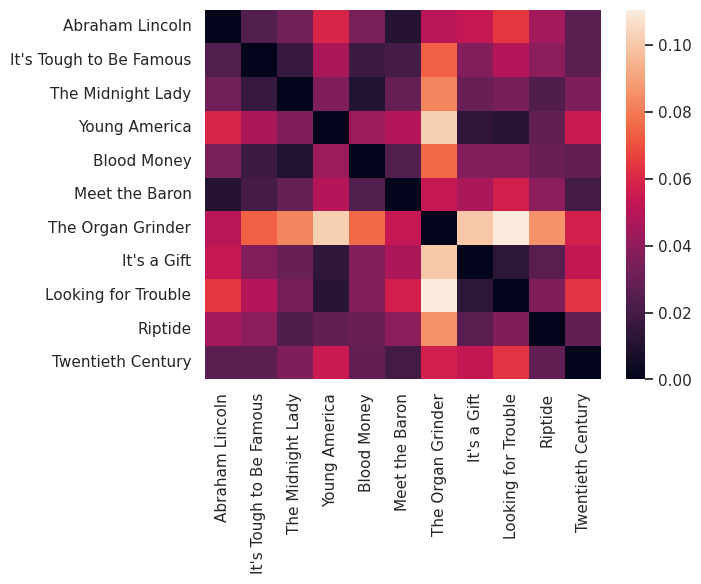

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

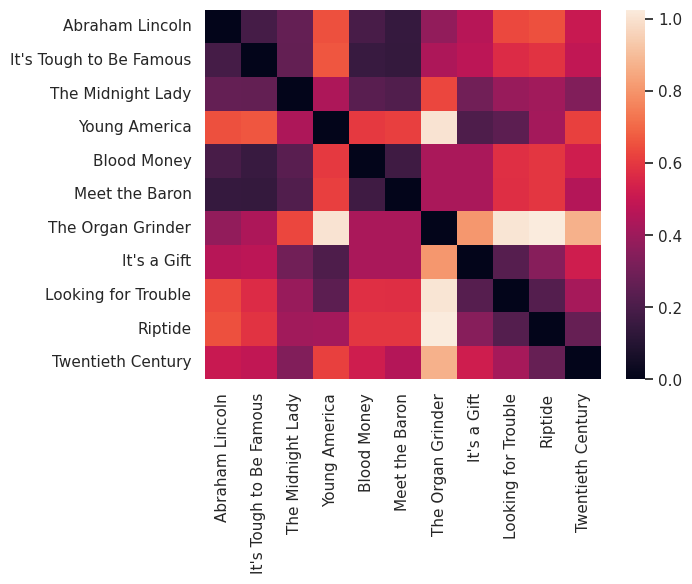

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

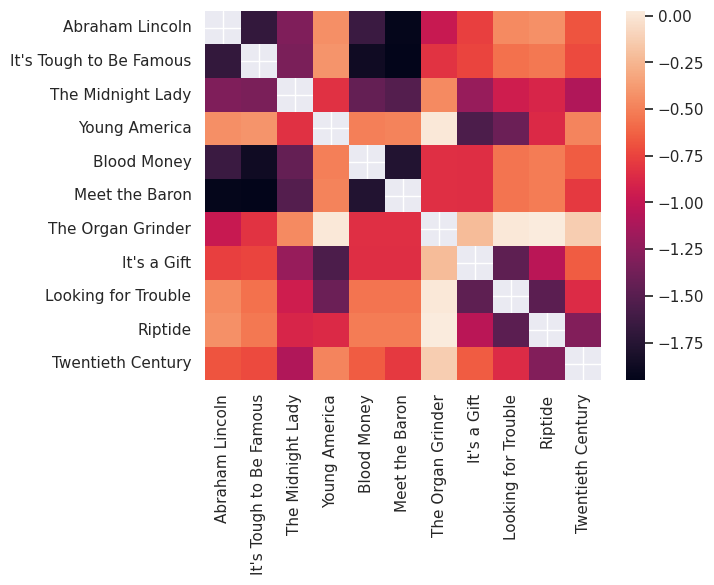

In [ ]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them.

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example. Here we again make use of our convenient `lucem_illud` functions, namely `loadTextDirectory`, which is found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

In [136]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [137]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Create the corpus file and generate the heatmap:

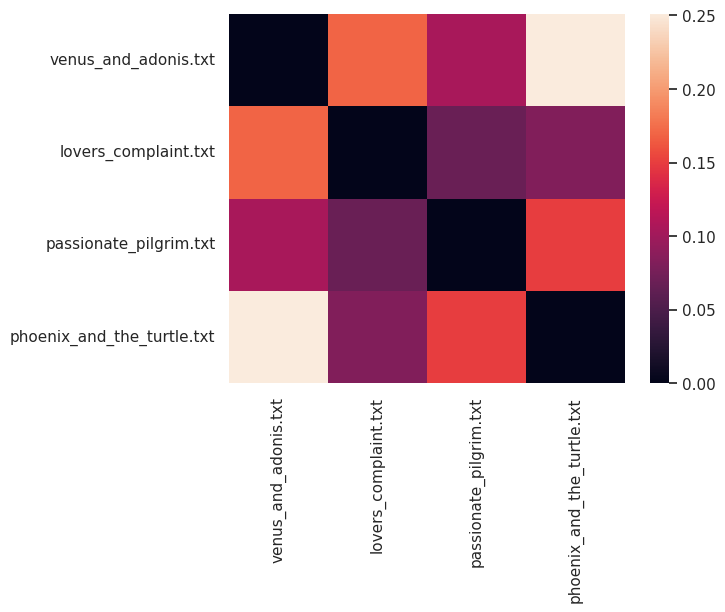

In [138]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <font color="red">*Exercise 7*</font>

<font color="red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better?

**Stretch**: Calculate the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) between your four corpora. What is the relationship between the KL and JS divergences?</font>

In [42]:
# Try this on Amiya, Kal'tist, Talulah, Ch'en 

amiya_text = main_plots_df[main_plots_df['Character'] == 'Amiya']['normalized_tokens'].sum()
kal_text = main_plots_df[main_plots_df['Character'] == 'Kal\'tsit']['normalized_tokens'].sum()
Talulah_text = main_plots_df[main_plots_df['Character'] == 'Talulah']['normalized_tokens'].sum()
Chen_text = main_plots_df[main_plots_df['Character'] == 'Ch\'en']['normalized_tokens'].sum()

In [44]:
amiya_words = set(amiya_text)
kal_words = set(kal_text)
Talulah_words = set(Talulah_text)
Chen_words = set(Chen_text)

In [48]:
def create_overlap_dict(*args):
    overlapWords = args[0]
    for arg in args[1:]:
        overlapWords = overlapWords & arg
    overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
    return overlapWordsDict

def makeProbsArray(words, overlapDict):
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

In [52]:
# amiya_prob_array = makeProbsArray(amiya_text, create_overlap_dict(amiya_words, kal_words, Talulah_words, Chen_words))
# kal_prob_array = makeProbsArray(kal_text, create_overlap_dict(amiya_words, kal_words, Talulah_words, Chen_words))
# Talulah_prob_array = makeProbsArray(Talulah_text, create_overlap_dict(amiya_words, kal_words, Talulah_words, Chen_words))
# Chen_prob_array = makeProbsArray(Chen_text, create_overlap_dict(amiya_words, kal_words, Talulah_words, Chen_words))

# amiya_prob_array.sum()

1.0

In [54]:
#KL divergence between Amiya and Kal'tsit
amiya_prob_array = makeProbsArray(amiya_text, create_overlap_dict(amiya_words, kal_words))
kal_prob_array = makeProbsArray(kal_text, create_overlap_dict(amiya_words, kal_words))

amiya_kalDivergence = scipy.stats.entropy(amiya_prob_array, kal_prob_array)
print (amiya_kalDivergence)
kal_amiyaDivergence = scipy.stats.entropy(kal_prob_array, amiya_prob_array)
print (kal_amiyaDivergence)


0.33944660736327725
0.31375711840940324


- This value is actually lower than the example used in demonstration; suggesting that two character speak in *more* similar manner

In [56]:
# matching words

amiya_kalDivergence_ew = scipy.special.kl_div(amiya_prob_array, kal_prob_array)
KL_df = pandas.DataFrame(list(create_overlap_dict(amiya_words, kal_words).keys()), 
                         columns = ['word'], 
                         index = list(create_overlap_dict(amiya_words, kal_words).values()))
KL_df = KL_df.sort_index()
KL_df['elementwise divergence'] = amiya_kalDivergence_ew
KL_df.sort_values(by='elementwise divergence', ascending=False)[:20]


,word,elementwise divergence
981,madam,0.022856
400,ch'en,0.021496
86,kal'tsit,0.011692
904,doctor,0.011382
204,miss,0.008680
500,amiya,0.008426
597,misha,0.007571
172,sorry,0.006116
783,huh,0.004320
125,londinium,0.004088


- the use of name diverge (though not a lot) between Amiya and Kal; e.g of course they won't talk about their own name as frequent as the other.


In [82]:
def Divergence(tokens1, tokens2, difference="KL", epsilon=1e-10):
    # Tokenize and create frequency distributions
    # tokens1 = nltk.tokenize.word_tokenize(corpus1)
    # tokens2 = nltk.tokenize.word_tokenize(corpus2)
    freq_dist1 = nltk.FreqDist(tokens1)
    freq_dist2 = nltk.FreqDist(tokens2)

    # Convert to probability distributions
    total1, total2 = sum(freq_dist1.values()), sum(freq_dist2.values())
    prob_dist1 = [(freq_dist1[word] + epsilon) / (total1 + epsilon * len(freq_dist1)) for word in freq_dist1]
    prob_dist2 = [(freq_dist2[word] + epsilon) / (total2 + epsilon * len(freq_dist2)) for word in freq_dist2]

    # Pad the shorter distribution with zeros
    len_diff = len(prob_dist1) - len(prob_dist2)
    if len_diff > 0:
        prob_dist2.extend([0] * len_diff)
    elif len_diff < 0:
        prob_dist1.extend([0] * abs(len_diff))

    # Calculate the divergence or distance
    if difference == "KL":
        # KL Divergence
        return scipy.stats.entropy(prob_dist1, prob_dist2)
    elif difference == "chi2":
        # Chi-squared Divergence
        return scipy.stats.chisquare(prob_dist1, prob_dist2)[0]
    elif difference == "KS":
        # Kolmogorov-Smirnov Distance
        return scipy.stats.ks_2samp(prob_dist1, prob_dist2)[0]
    elif difference == "Wasserstein":
        # Wasserstein Distance
        return scipy.stats.wasserstein_distance(prob_dist1, prob_dist2)
    else:
        raise ValueError("Invalid divergence/distance type")


In [85]:
a = Divergence( amiya_text, kal_text, difference="KL")
a

0.02756951161110157

In [79]:
def create_divergence_matrix(characters, divergence_matrix, difference="KL"):
    for i in range(len(characters)):
        for j in range(len(characters)):
            divergence_matrix[i][j] = Divergence(characters[i], characters[j], difference)
    return divergence_matrix


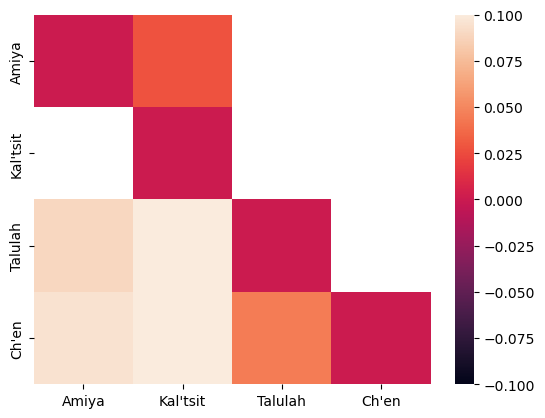

In [80]:
# KL divergence matrix
characters = [amiya_text, kal_text, Talulah_text, Chen_text]
divergence_matrix = np.zeros((len(characters), len(characters)))
divergence_matrix = create_divergence_matrix(characters, divergence_matrix, difference="KL")

# plot the heatmap

fig = plt.figure()

div = pandas.DataFrame(divergence_matrix, columns = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'], index = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'])
ax = sns.heatmap(div)
plt.show()

- I suspect there is a zero-frequency problem for KL calculation observed in many cells (entirely white)


c:\Users\Admin\anaconda3\envs\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


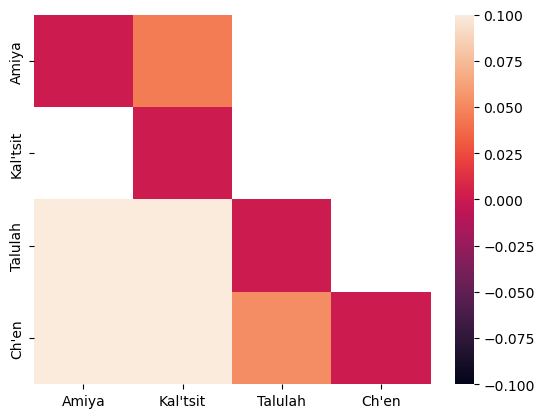

In [83]:
# Chi2 divergence matrix
divergence_matrix = np.zeros((len(characters), len(characters)))
divergence_matrix = create_divergence_matrix(characters, divergence_matrix, difference="chi2")

# plot the heatmap

fig = plt.figure()

div = pandas.DataFrame(divergence_matrix, columns = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'], index = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'])
ax = sns.heatmap(div)
plt.show()

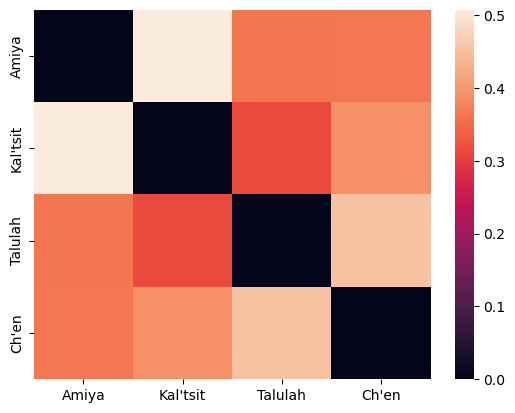

In [84]:
# KS divergence matrix

divergence_matrix = np.zeros((len(characters), len(characters)))
divergence_matrix = create_divergence_matrix(characters, divergence_matrix, difference="KS")

# plot the heatmap

fig = plt.figure()

div = pandas.DataFrame(divergence_matrix, columns = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'], index = ['Amiya', 'Kal\'tsit', 'Talulah', 'Ch\'en'])
ax = sns.heatmap(div)
plt.show()